#### **Comparison of static mvo portfolio vs ML + Factors Beta based contraints + filtered covariance**   

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [2]:
hf_df = pd.read_excel("Data/hedge_funds_returns_data.xlsx")
short_mapping = {
    'Date': 'Date',
    'HFRI 400 (US) Fund Weighted Composite Index (HFRI4FWC)': 'HFRI4FWC',
    'HFRI 400 (US) EH: Long/Short Index (HFRI4ELS)': 'HFRI4ELS',
    'HFRI 400 (US) EH: Fundamental Value Index (HFRI4EHV)': 'HFRI4EHV',
    'HFRI 400 (US) Event-Driven Index (HFRI4ED)': 'HFRI4ED'
    
}

hf_df = hf_df.rename(columns=short_mapping)
def clean_data(df):
    df = df.set_index('Date')
    df = df.dropna()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    return df
    
hf_df = clean_data(hf_df)

In [3]:
# MVO Optimal Portfolio Weights
mvo_05 = pd.read_excel('all_output_results/mvo_weights_λ=0.05.xlsx')
mvo_10 = pd.read_excel('all_output_results/mvo_weights_λ=10.xlsx')

In [4]:
# ML+factors beta based contraints + filtered covariance portfolio weights
portfolio_weights_05 = pd.read_excel('all_output_results/agg_portfolio_weights.xlsx')
portfolio_weights_10 = pd.read_excel('all_output_results/cons_portfolio_weights.xlsx')

In [5]:
def calculate_monthly_portfolio_returns():
    """Calculate monthly portfolio returns for both risk aversion levels"""
    
    # Get fund columns (exclude 'Quarter' column)
    fund_columns = [col for col in portfolio_weights_05.columns if col != 'Quarter']
    
    # Create a dictionary to store weights by quarter
    weights_dict_05 = {}
    weights_dict_10 = {}
    
    # Process weights from both DataFrames
    for _, row in portfolio_weights_05.iterrows():
        quarter = row['Quarter']
        weights = []
        for fund in fund_columns:
            weight = row[fund]
            if isinstance(weight, str) and '%' in weight:
                weight = float(weight.replace('%', '')) / 100
            weights.append(weight)
        weights_dict_05[quarter] = weights
    
    for _, row in portfolio_weights_10.iterrows():
        quarter = row['Quarter']
        weights = []
        for fund in fund_columns:
            weight = row[fund]
            if isinstance(weight, str) and '%' in weight:
                weight = float(weight.replace('%', '')) / 100
            weights.append(weight)
        weights_dict_10[quarter] = weights
    
    # Function to get quarter from date
    def get_quarter_from_date(date):
        year = date.year
        quarter_num = (date.month - 1) // 3 + 1
        return f"Q{quarter_num} {year}"
    
    # Calculate monthly returns
    monthly_returns_data = []
    
    for date in hf_df.index:
        quarter = get_quarter_from_date(date)
        
        # Check if we have weights for this quarter
        if quarter in weights_dict_05 and quarter in weights_dict_10:
            # Get monthly returns for all funds
            monthly_fund_returns = hf_df.loc[date, fund_columns].values
            
            # Calculate portfolio returns
            portfolio_return_05 = sum(w * r for w, r in zip(weights_dict_05[quarter], monthly_fund_returns))
            portfolio_return_10 = sum(w * r for w, r in zip(weights_dict_10[quarter], monthly_fund_returns))
            
            # Multiply by 100 to get percentage returns
            monthly_returns_data.append({
                'Date': date,
                'Risk_Aversion_05': portfolio_return_05,
                'Risk_Aversion_10': portfolio_return_10
            })
    
    # Create DataFrame
    df_monthly_returns = pd.DataFrame(monthly_returns_data)
    df_monthly_returns.set_index('Date', inplace=True)
    
    return df_monthly_returns

In [6]:
def calculate_monthly_portfolio_returns_mvo():
    """Calculate monthly portfolio returns for both risk aversion levels using MVO weights"""
    
    # Get fund columns (exclude 'Quarter' column)
    fund_columns = [col for col in mvo_05.columns if col != 'Quarter']
    
    # Create a dictionary to store weights by quarter
    weights_dict_05 = {}
    weights_dict_10 = {}
    
    # Process weights from both MVO DataFrames
    for _, row in mvo_05.iterrows():
        quarter = row['Quarter']
        weights = []
        for fund in fund_columns:
            weight = row[fund]
            if isinstance(weight, str) and '%' in weight:
                weight = float(weight.replace('%', '')) / 100
            weights.append(weight)
        weights_dict_05[quarter] = weights
    
    for _, row in mvo_10.iterrows():
        quarter = row['Quarter']
        weights = []
        for fund in fund_columns:
            weight = row[fund]
            if isinstance(weight, str) and '%' in weight:
                weight = float(weight.replace('%', '')) / 100
            weights.append(weight)
        weights_dict_10[quarter] = weights
    
    # Function to get quarter from date
    def get_quarter_from_date(date):
        year = date.year
        quarter_num = (date.month - 1) // 3 + 1
        return f"Q{quarter_num} {year}"
    
    # Calculate monthly returns
    monthly_returns_data = []
    
    for date in hf_df.index:
        quarter = get_quarter_from_date(date)
        
        # Check if we have weights for this quarter
        if quarter in weights_dict_05 and quarter in weights_dict_10:
            # Get monthly returns for all funds
            monthly_fund_returns = hf_df.loc[date, fund_columns].values
            
            # Calculate portfolio returns
            portfolio_return_05 = sum(w * r for w, r in zip(weights_dict_05[quarter], monthly_fund_returns))
            portfolio_return_10 = sum(w * r for w, r in zip(weights_dict_10[quarter], monthly_fund_returns))
            
            monthly_returns_data.append({
                'Date': date,
                'MVO_Risk_Aversion_05': portfolio_return_05,
                'MVO_Risk_Aversion_10': portfolio_return_10
            })
    
    # Create DataFrame
    df_monthly_returns = pd.DataFrame(monthly_returns_data)
    df_monthly_returns.set_index('Date', inplace=True)
    
    return df_monthly_returns

In [7]:
# Calculate monthly returns
ML_returns = calculate_monthly_portfolio_returns_mvo()
ML_returns.head(5)

,MVO_Risk_Aversion_05,MVO_Risk_Aversion_10
Date,,
2012-01-31,0.0351,0.0225
2012-02-29,0.0311,0.0193
2012-03-30,0.0012,-0.0008
2012-04-30,-0.0055,-0.0023
2012-05-31,-0.0445,-0.0215


In [8]:
# Calculate monthly returns using MVO weights
mvo_monthly_returns = calculate_monthly_portfolio_returns()
mvo_monthly_returns.head()

,Risk_Aversion_05,Risk_Aversion_10
Date,,
2012-01-31,0.0372,0.0372
2012-02-29,0.0316,0.0316
2012-03-30,0.0061,0.0061
2012-04-30,-0.0023,-0.0023
2012-05-31,-0.0215,-0.0215


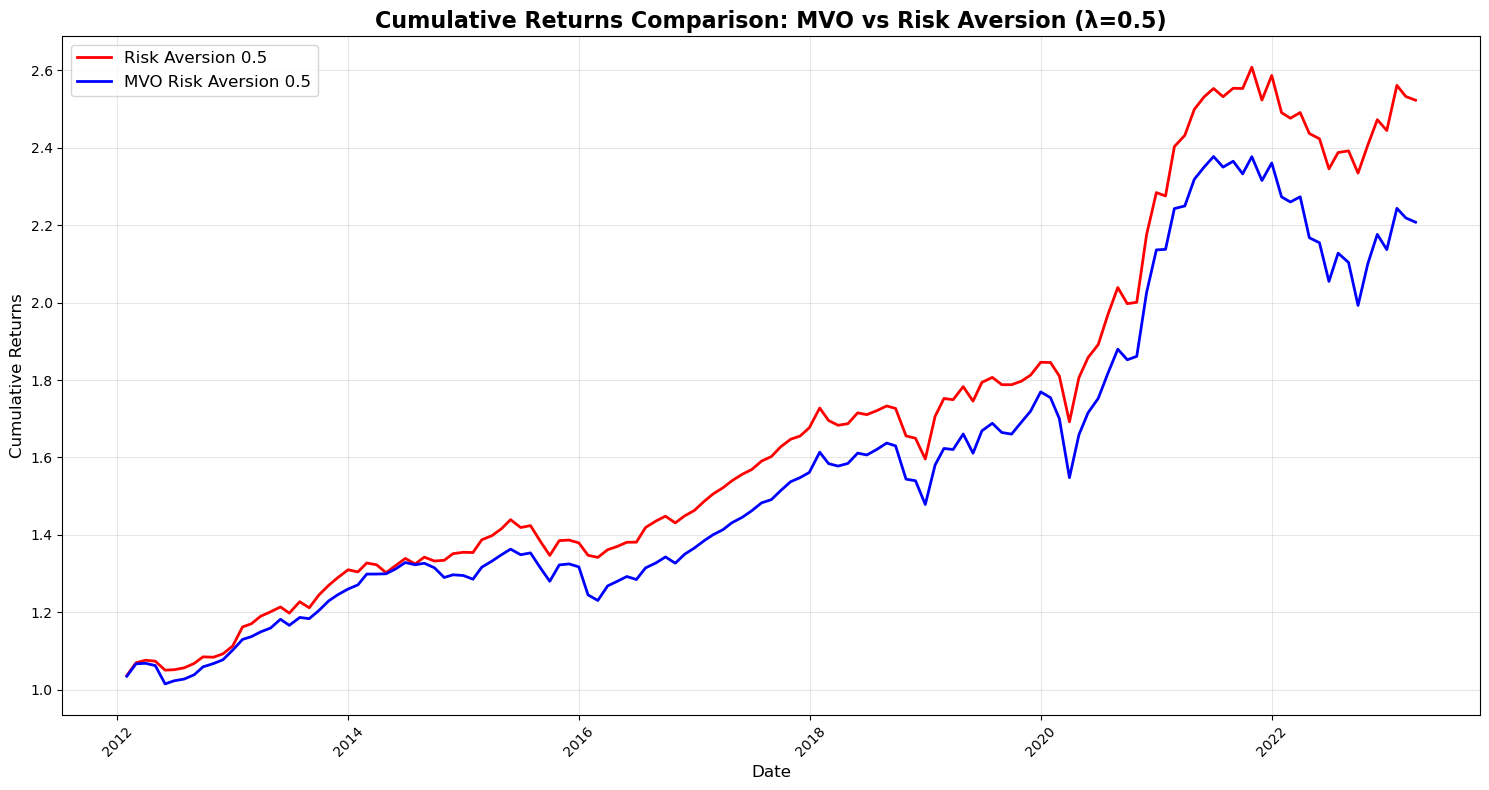

In [9]:
# Calculate cumulative returns
mvo_cumulative = (1 + ML_returns['MVO_Risk_Aversion_05']).cumprod()
risk_aversion_cumulative = (1 + mvo_monthly_returns['Risk_Aversion_05']).cumprod()

# Create cumulative returns chart
plt.figure(figsize=(15, 8))
plt.plot(risk_aversion_cumulative.index, risk_aversion_cumulative, 
         label='Risk Aversion 0.5', linewidth=2, color='red')
plt.plot(mvo_cumulative.index, mvo_cumulative, 
         label='MVO Risk Aversion 0.5', linewidth=2, color='blue')

plt.title('Cumulative Returns Comparison: MVO vs Risk Aversion (λ=0.5)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

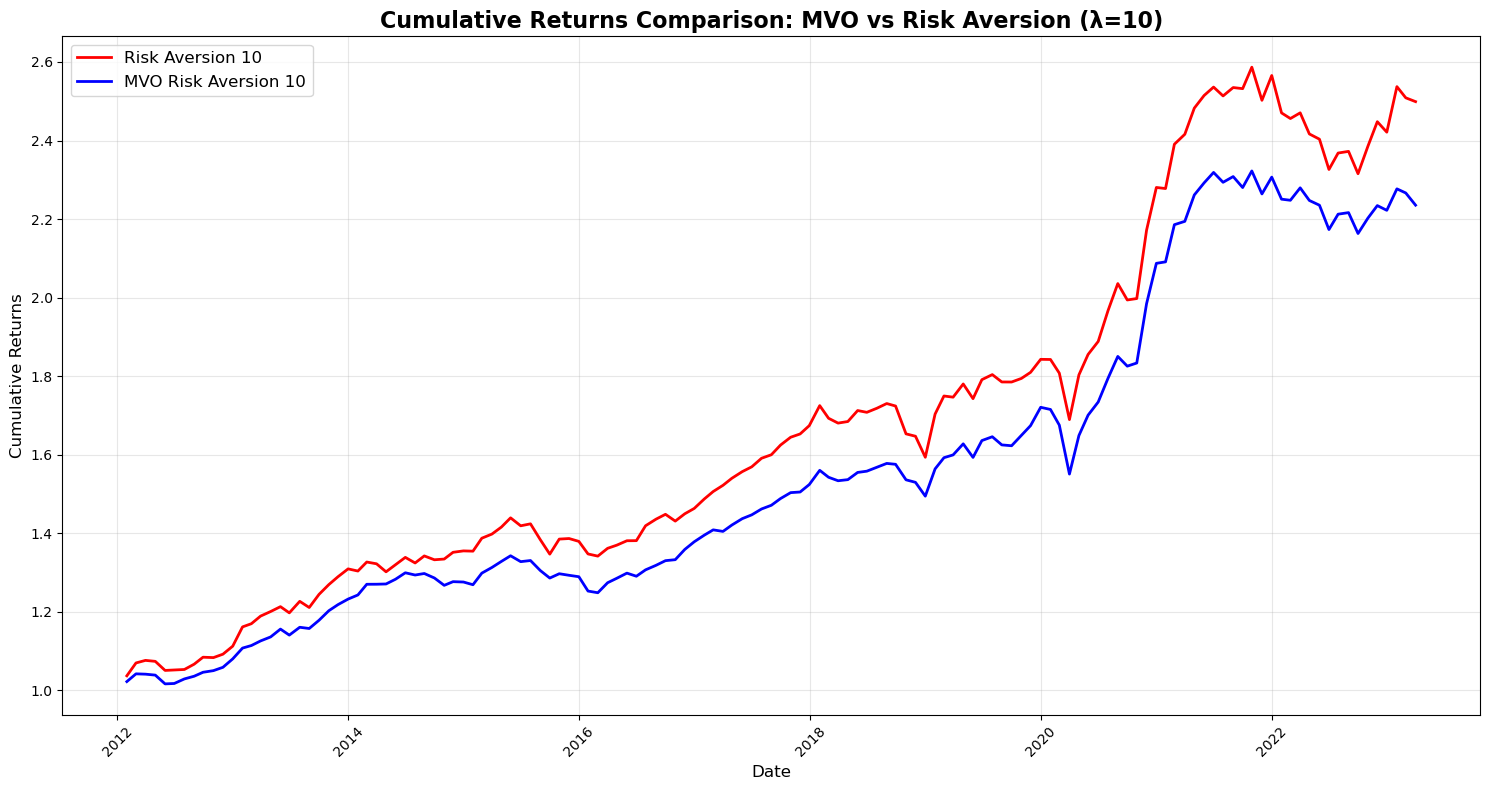

In [10]:
# Calculate cumulative returns for risk aversion 10
mvo_cumulative_10 = (1 + ML_returns['MVO_Risk_Aversion_10']).cumprod()
risk_aversion_cumulative_10 = (1 + mvo_monthly_returns['Risk_Aversion_10']).cumprod()

# Create cumulative returns chart
plt.figure(figsize=(15, 8))
plt.plot(risk_aversion_cumulative_10.index, risk_aversion_cumulative_10, 
         label='Risk Aversion 10', linewidth=2, color='red')
plt.plot(mvo_cumulative_10.index, mvo_cumulative_10, 
         label='MVO Risk Aversion 10', linewidth=2, color='blue')

plt.title('Cumulative Returns Comparison: MVO vs Risk Aversion (λ=10)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Create performance DataFrame
asset_perf = pd.DataFrame(dtype=float, columns=['return', 'vol', 'Sharpe', 'Max Drawdown'])

# Create a combined DataFrame for the two strategies
comparison_returns = pd.DataFrame({
    'Risk_Aversion_05': mvo_monthly_returns['Risk_Aversion_05'],
    'MVO_Risk_Aversion_05': ML_returns['MVO_Risk_Aversion_05']
})

# Calculate cumulative returns for both strategies
asset_cum_returns = (1 + comparison_returns).cumprod()

# Calculate performance metrics
asset_perf['return'] = (asset_cum_returns.iloc[-1] ** (1/(asset_cum_returns.shape[0]/12)) - 1) * 100
asset_perf['vol'] = comparison_returns.std() * np.sqrt(12) * 100
asset_perf['Sharpe'] = asset_perf['return']/asset_perf['vol']
asset_perf['Max Drawdown'] = (1 - asset_cum_returns/asset_cum_returns.cummax()).max() * 100

print("Performance Comparison: MVO_Risk_Aversion_05 vs Risk_Aversion_05")
asset_perf

Performance Comparison: MVO_Risk_Aversion_05 vs Risk_Aversion_05


,return,vol,Sharpe,Max Drawdown
Risk_Aversion_05,8.572332,7.430682,1.153640,10.488248
MVO_Risk_Aversion_05,7.292643,8.670005,0.841135,16.171094


In [12]:
asset_perf_10 = pd.DataFrame(dtype=float, columns=['return', 'vol', 'Sharpe', 'Max Drawdown'])

comparison_returns_10 = pd.DataFrame({
    'Risk_Aversion_10': mvo_monthly_returns['Risk_Aversion_10'],
    'MVO_Risk_Aversion_10': ML_returns['MVO_Risk_Aversion_10']
})


asset_cum_returns_10 = (1 + comparison_returns_10).cumprod()


asset_perf_10['return'] = (asset_cum_returns_10.iloc[-1] ** (1/(asset_cum_returns_10.shape[0]/12)) - 1) * 100
asset_perf_10['vol'] = comparison_returns_10.std() * np.sqrt(12) * 100
asset_perf_10['Sharpe'] = asset_perf_10['return']/asset_perf_10['vol']
asset_perf_10['Max Drawdown'] = (1 - asset_cum_returns_10/asset_cum_returns_10.cummax()).max() * 100

print("Performance Comparison: MVO_Risk_Aversion_10 vs Risk_Aversion_10")
asset_perf_10

Performance Comparison: MVO_Risk_Aversion_10 vs Risk_Aversion_10


,return,vol,Sharpe,Max Drawdown
Risk_Aversion_10,8.481738,7.392252,1.147382,10.488248
MVO_Risk_Aversion_10,7.412334,6.420927,1.154402,9.879349
